# Imports

In [127]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [128]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/cube.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 8
Number of edges: 18


In [129]:
print(graph._node)

{(0.0, 0.0, 0.0): {'index_triangle': {0, 1, 2, 3, 8, 9}}, (1.0, 0.0, 1.0): {'index_triangle': {0, 1, 4, 6}}, (1.0, 0.0, 0.0): {'index_triangle': {0, 8, 6, 7}}, (0.0, 0.0, 1.0): {'index_triangle': {1, 2, 4, 5}}, (0.0, -1.0, 1.0): {'index_triangle': {11, 2, 3, 5}}, (0.0, -1.0, 0.0): {'index_triangle': {11, 9, 10, 3}}, (1.0, -1.0, 1.0): {'index_triangle': {4, 5, 6, 7, 10, 11}}, (1.0, -1.0, 0.0): {'index_triangle': {8, 9, 10, 7}}}


# Point Sampler

### DevConv

In [130]:
class DevConv():
    def __init__(self, graph):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.array([0.1])      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, is_relu=True):
        list_inc_score_before_function = np.zeros(shape=(len(self.list_node)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node)))   # norm(W_theta * (xi - xj))
            # print(neigh_distances)
            list_inc_score_before_function[index_current_node] = self.W_phi[0] * np.max(neigh_distances)
            # print(list_inc_score_before_function)

        # apply non linear function
        if is_relu:
            list_inc_score = np.maximum(list_inc_score_before_function, 0)
        else:
            list_inc_score = 1 / (1 + np.exp(-list_inc_score_before_function))

        # merge with previous inclusion score
        if previous_inclusion_score!=None:
            return np.mean(previous_inclusion_score, list_inc_score)
        return list_inc_score

In [131]:
devconv = DevConv(graph)
inclusion_score = devconv.forward(previous_inclusion_score=None, is_relu=False)
print(inclusion_score)

[0.58917481 0.57840466 0.58917481 0.57444252 0.58917481 0.57840466
 0.58917481 0.57444252]


### Multinomial Sampling

In [132]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[57 61 67 66 60 61 59 69]


In [133]:
target_number_point = min(len(graph._node), 5)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(1.0, 0.0, 1.0), (0.0, -1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), (1.0, -1.0, 0.0)]


# KNN

In [134]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[1.0, 0.0, 1.0], [0.0, -1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [1.0, -1.0, 0.0]]


In [135]:
number_neigh = min(len(XYZ), 3)
distances, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
print(indices)

[[0 2 3]
 [1 4 2]
 [2 0 1]
 [3 4 0]
 [4 1 3]]


In [136]:
extended_graph = nx.Graph()
for index_poly, poly in enumerate(indices):
    for index_current_node in range(len(poly)):
        current_node = list_k_nodes[poly[index_current_node]]
        for index_other_node in range(index_current_node+1, len(poly)):
            edge = current_node, list_k_nodes[poly[index_other_node]]
            print(edge)
            extended_graph.add_edge(*edge)
            # if attribute do not exists
            if len(extended_graph.nodes[current_node])==0:
                extended_graph.nodes[current_node]['index_poly'] = set()
            extended_graph.nodes[current_node]['index_poly'].add(index_poly)

((1.0, 0.0, 1.0), (0.0, 0.0, 1.0))
((1.0, 0.0, 1.0), (1.0, 0.0, 0.0))
((0.0, 0.0, 1.0), (1.0, 0.0, 0.0))
((0.0, -1.0, 0.0), (1.0, -1.0, 0.0))
((0.0, -1.0, 0.0), (0.0, 0.0, 1.0))
((1.0, -1.0, 0.0), (0.0, 0.0, 1.0))
((0.0, 0.0, 1.0), (1.0, 0.0, 1.0))
((0.0, 0.0, 1.0), (0.0, -1.0, 0.0))
((1.0, 0.0, 1.0), (0.0, -1.0, 0.0))
((1.0, 0.0, 0.0), (1.0, -1.0, 0.0))
((1.0, 0.0, 0.0), (1.0, 0.0, 1.0))
((1.0, -1.0, 0.0), (1.0, 0.0, 1.0))
((1.0, -1.0, 0.0), (0.0, -1.0, 0.0))
((1.0, -1.0, 0.0), (1.0, 0.0, 0.0))
((0.0, -1.0, 0.0), (1.0, 0.0, 0.0))


In [137]:
print(extended_graph._node)

{(1.0, 0.0, 1.0): {'index_poly': {0, 2}}, (0.0, 0.0, 1.0): {'index_poly': {0, 2}}, (1.0, 0.0, 0.0): {'index_poly': {3}}, (0.0, -1.0, 0.0): {'index_poly': {1, 4}}, (1.0, -1.0, 0.0): {'index_poly': {1, 3, 4}}}


Number of nodes: 5
Number of edges: 10


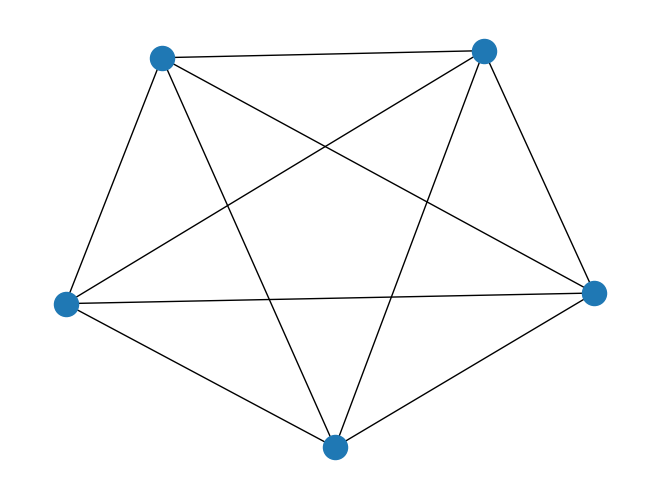

In [138]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [139]:
#devconv

### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh